# **Project Title : Plant Disease Classification**

# **Preliminary EDA of the dataset**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing all the necessary libraries**

In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## **Dataset loading and preprocessing**

In [ ]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3

# Dataset path in Google Drive
dataset_path = '/content/drive/MyDrive/606_dataset/PlantVillage'

# Verify dataset path exists
if not os.path.exists(dataset_path):
    print("Dataset directory does not exist!")
    exit()

# Load data into TensorFlow dataset
tfdataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
# The dataset is classified into three classes
class_names = tfdataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
num_samples = len(tfdataset) * BATCH_SIZE
print("Total number of samples:", num_samples)

Total number of samples: 2176


## The length of the dataset is 68 and each containing the batch size of 32 elements in it and the total samples are 2176 images in the dataset


In [ ]:
# Iterate over the first batch of images and labels in the dataset and printing the shape of the image batch and the numpy array representation of the labels batch
for image_batch, labels_batch in tfdataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [ ]:
# Iterate over the first batch of images and labels in the dataset and printing the numpy array of the first image in the batch
for image_batch, labels_batch in tfdataset.take(1):
    print(image_batch[0].numpy())

[[[163. 161. 172.]
  [129. 127. 138.]
  [108. 106. 117.]
  ...
  [163. 161. 175.]
  [158. 156. 170.]
  [153. 151. 165.]]

 [[149. 147. 158.]
  [ 98.  96. 107.]
  [144. 142. 153.]
  ...
  [159. 157. 171.]
  [165. 163. 177.]
  [168. 166. 180.]]

 [[100.  98. 109.]
  [117. 115. 126.]
  [188. 186. 199.]
  ...
  [163. 161. 175.]
  [164. 162. 176.]
  [164. 162. 176.]]

 ...

 [[142. 138. 153.]
  [120. 116. 131.]
  [136. 132. 147.]
  ...
  [180. 178. 191.]
  [178. 176. 189.]
  [189. 187. 200.]]

 [[118. 114. 129.]
  [102.  98. 113.]
  [157. 153. 168.]
  ...
  [177. 175. 188.]
  [172. 170. 183.]
  [177. 175. 188.]]

 [[123. 119. 134.]
  [128. 124. 139.]
  [148. 144. 159.]
  ...
  [205. 203. 216.]
  [188. 186. 199.]
  [173. 171. 184.]]]


## **Plotting Class distribution in bar graph**

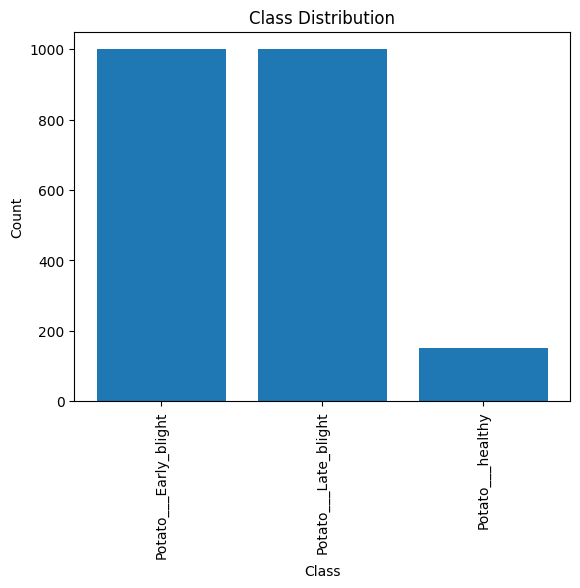

In [ ]:
# Initialize an empty dictionary for class counts
class_counts = {class_name: 0 for class_name in class_names}

# Iterate over the dataset and count the occurrences of each class
for _, labels_batch in tfdataset:
    for label in labels_batch.numpy():
        class_counts[class_names[label]] += 1

# Plot the class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

## **Computing Image Statistics**

In [ ]:
# Initialize empty lists to store mean and standard deviation values
mean_values = []
std_values = []

# Iterate over the dataset batches
for image_batch, _ in tfdataset:
    mean = tf.math.reduce_mean(image_batch, axis=(0, 1, 2))
    std = tf.math.reduce_std(image_batch, axis=(0, 1, 2))
    mean_values.append(mean)
    std_values.append(std)
mean_values = tf.reduce_mean(mean_values, axis=0)
std_values = tf.reduce_mean(std_values, axis=0)
print("Mean RGB values:", mean_values.numpy())
print("Std Dev RGB values:", std_values.numpy())

Mean RGB values: [126.047264 130.49966  108.87487 ]
Std Dev RGB values: [48.86756  45.348892 54.71175 ]


## **Visualization of Sample Dataset**

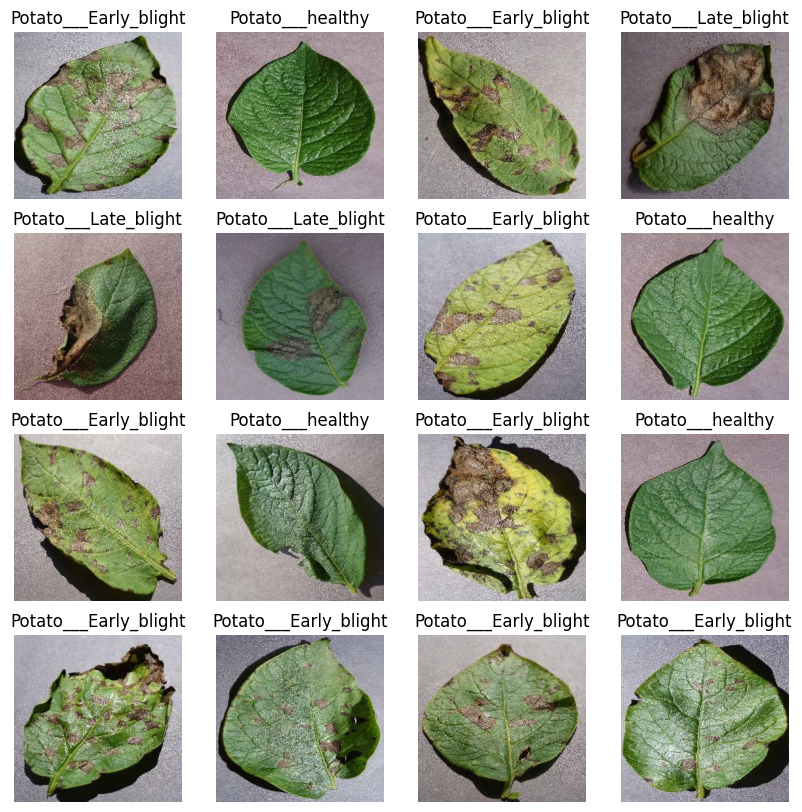

In [ ]:
# Visualize a sample from the dataset
plt.figure(figsize=(10, 10))
for images, labels in tfdataset.take(3):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## **Visualizing data augumentation**

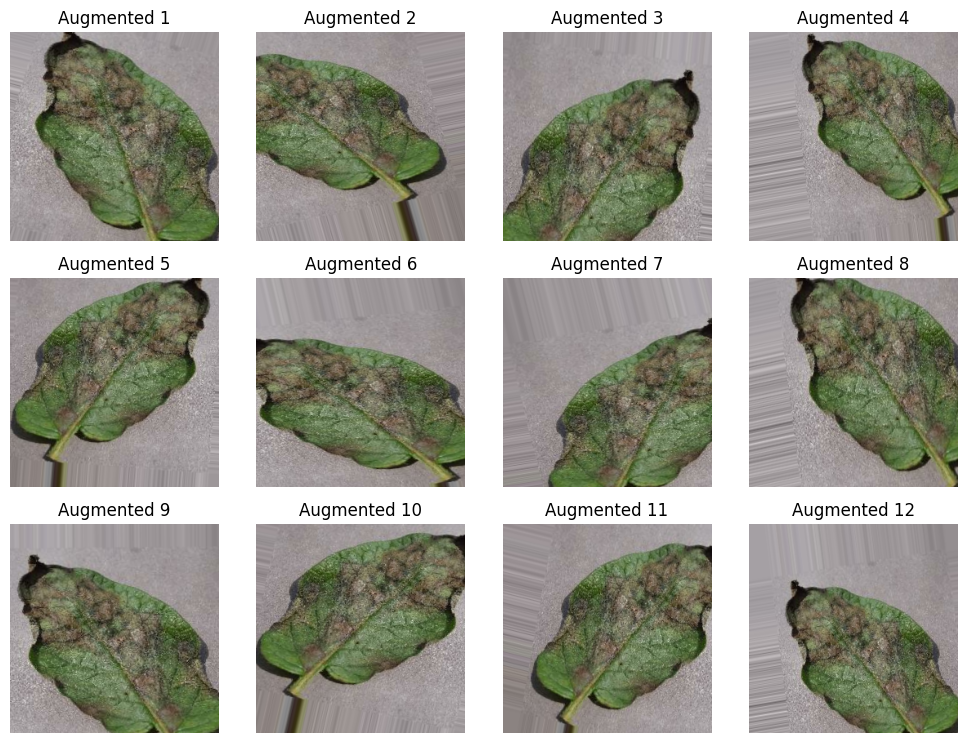

In [ ]:
# Convert the sample image to a NumPy array
sample_image = next(iter(tfdataset))[0][0].numpy()

# Create an instance of the ImageDataGenerator with desired augmentation options
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
augmented_images = []
for _ in range(12):
    augmented_image = data_generator.random_transform(sample_image)
    augmented_images.append(augmented_image)

# Plot the original and augmented images
plt.figure(figsize=(10, 10))
plt.subplot(4, 4, 1)
plt.imshow(sample_image.astype("uint8"))
plt.title("Original")
plt.axis("off")

for i, image in enumerate(augmented_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title("Augmented " + str(i + 1))
    plt.axis("off")

plt.tight_layout()
plt.show()

## **Describing image statistics**

In [ ]:
# Variables to accumulate mean and standard deviation values
mean_values = tf.zeros((3,), dtype=tf.float32)
variance_values = tf.zeros((3,), dtype=tf.float32)
count = tf.constant(0, dtype=tf.float32)

# Iterate over the dataset and calculate mean and variance
for image_batch, _ in tfdataset:
    # Calculate the mean for each channel
    mean = tf.reduce_mean(image_batch, axis=(0, 1))

    # Calculate the variance for each channel
    variance = tf.reduce_mean(tf.math.squared_difference(image_batch, mean), axis=(0, 1))

    # Accumulate the mean and variance values
    mean_values += mean
    variance_values += variance
    count += tf.cast(tf.shape(image_batch)[0], tf.float32)

# Calculate the final mean and standard deviation
mean_values /= count
std_values = tf.sqrt(variance_values / count)

# Print the mean results of Red, Green and Blue channels
print("Mean RGB values:", mean_values.numpy())

Mean RGB values: [[4.7997346 4.5597363 4.753262 ]
 [4.7881002 4.5498037 4.7398615]
 [4.77849   4.5393057 4.7281947]
 [4.761316  4.5244594 4.707679 ]
 [4.7496743 4.512061  4.691721 ]
 [4.7334127 4.498906  4.670593 ]
 [4.713494  4.4808273 4.6445894]
 [4.69351   4.4654636 4.617486 ]
 [4.671853  4.446998  4.587138 ]
 [4.6465063 4.428491  4.5514975]
 [4.626338  4.4129605 4.518181 ]
 [4.6001377 4.3953934 4.479067 ]
 [4.5777316 4.378663  4.442324 ]
 [4.551948  4.360649  4.4046135]
 [4.5302205 4.3423214 4.372693 ]
 [4.502115  4.3268833 4.3290334]
 [4.4785194 4.3100343 4.281234 ]
 [4.44627   4.2929444 4.232056 ]
 [4.425776  4.2758827 4.200166 ]
 [4.3985157 4.2610197 4.1591506]
 [4.377299  4.2465677 4.1223555]
 [4.3528366 4.236944  4.0825343]
 [4.331308  4.2254024 4.045876 ]
 [4.3049526 4.2150354 4.0051804]
 [4.281814  4.202107  3.9688761]
 [4.257055  4.1936235 3.9303837]
 [4.2365866 4.1830654 3.896268 ]
 [4.210291  4.1726236 3.8567502]
 [4.1910605 4.1620393 3.8248327]
 [4.17035   4.1544595 3.79

In [ ]:
# Print the std Dev results of Red, Green and Blue channels
print("Std Dev RGB values:", std_values.numpy())

Std Dev RGB values: [[ 6.7526956  6.811025   7.1348534]
 [ 6.8357677  6.885795   7.2200027]
 [ 6.9612255  7.002261   7.35657  ]
 [ 7.0817924  7.110647   7.486194 ]
 [ 7.2033772  7.22159    7.6283264]
 [ 7.321965   7.3237224  7.766073 ]
 [ 7.4371653  7.4184027  7.9163933]
 [ 7.5756245  7.5309396  8.087962 ]
 [ 7.700938   7.6274076  8.259044 ]
 [ 7.7875     7.6838903  8.399967 ]
 [ 7.8955054  7.765949   8.571173 ]
 [ 7.984902   7.823417   8.714533 ]
 [ 8.062614   7.8742023  8.848789 ]
 [ 8.144668   7.92668    8.985682 ]
 [ 8.206853   7.973488   9.1055975]
 [ 8.291778   8.026488   9.234207 ]
 [ 8.386287   8.070151   9.363211 ]
 [ 8.443868   8.083014   9.480217 ]
 [ 8.492031   8.123519   9.548303 ]
 [ 8.539684   8.144944   9.628465 ]
 [ 8.574508   8.165069   9.708776 ]
 [ 8.618308   8.173415   9.789549 ]
 [ 8.636708   8.165184   9.845717 ]
 [ 8.689462   8.185537   9.9203825]
 [ 8.717683   8.19616    9.961064 ]
 [ 8.731646   8.18218    9.993187 ]
 [ 8.76389    8.199781  10.034619 ]
 [ 8.790

## **Finding the length of the dataset the train, test and validation depending on the batch sizes of each element and their classes**

In [ ]:
len(tfdataset) # length of the dataset

68

In [ ]:
training_size = 0.8 # trainiing dataset proportion
len(tfdataset)*training_size

54.400000000000006

In [ ]:
train_dataset = tfdataset.take(54) # training dataset
len(train_dataset)

54

In [ ]:
rem_dataset = tfdataset.skip(54) # remaining dataset after training
len(rem_dataset)

14

In [ ]:
validation_size = 0.1
len(tfdataset)*validation_size

6.800000000000001

In [ ]:
val_dataset = rem_dataset.take(6) # validation dataset
len(val_dataset)

6

In [ ]:
test_dataset = rem_dataset.skip(6) # test dataset
len(test_dataset)

8

## **Splitting the dataset into train, test and validation in 8:1:1 ratios for the model training.**

In [ ]:
# Define a function to split the dataset into training, validation, and test datasets
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=7)

    # Calculate the sizes of the training, validation, and test datasets
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    # Create the training,validation and test datasets by taking the first data elements from the shuffled dataset
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)
    return train_dataset, val_dataset, test_dataset

# Split the tfdataset into training, validation, and test datasets using the get_dataset_partitions_tf function
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(tfdataset)
print("length of trained dataset is:", len(train_dataset))
print("length of validation dataset is:", len(val_dataset))
print("length of test dataset is:", len(test_dataset))

length of trained dataset is: 54
length of validation dataset is: 6
length of test dataset is: 8


## **Preprocessing and Optimization of the datasets**

In [ ]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # Cache, shuffle, and prefetch training dataset
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # Cache, shuffle, and prefetch validating dataset
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # Cache, shuffle, and prefetch testing dataset
print(train_dataset)
print(val_dataset)
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## **Data Transformation, Resizing and Normalization Layer.**

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)
])

## **Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## **Applying Data Augmentation to Train Dataset**

In [ ]:
def apply_data_augmentation(x, y):
    augmented_x = data_augmentation(x, training=True)
    return augmented_x, y

# Apply data augmentation to the training dataset using the defined function
train_dataset = train_dataset.map(apply_data_augmentation)

# Prefetch the data to optimize training performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## **Model Building**

## **CNN Model Architecture**

In [ ]:
from tensorflow.keras import models, layers, Input
no_of_classes = 3

# Input layer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
resize_and_rescale = layers.Rescaling(1./255)(inputs)

# Convolutional layers
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(resize_and_rescale)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten and dense layers
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(no_of_classes, activation='softmax')(x)

# Create the model
CNN_model = models.Model(inputs=inputs, outputs=outputs)

In [ ]:
CNN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                         

## **Compiling the CNN_model with adam optimizer and accuracy as the metric**

In [ ]:
# Compile the model
CNN_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## **Training the CNN model using fit() Method**

In [ ]:
# Training the model
model_train1 = CNN_model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=25,
)

Epoch 1/25
54/54 [==============================] - 27s 253ms/step - loss: 0.8881 - accuracy: 0.5188 - val_loss: 0.7052 - val_accuracy: 0.7917
Epoch 2/25
54/54 [==============================] - 13s 235ms/step - loss: 0.5947 - accuracy: 0.7529 - val_loss: 0.3746 - val_accuracy: 0.8490
Epoch 3/25
54/54 [==============================] - 13s 235ms/step - loss: 0.2937 - accuracy: 0.8797 - val_loss: 0.2599 - val_accuracy: 0.9115
Epoch 4/25
54/54 [==============================] - 13s 237ms/step - loss: 0.2557 - accuracy: 0.8955 - val_loss: 0.2671 - val_accuracy: 0.9115
Epoch 5/25
54/54 [==============================] - 13s 235ms/step - loss: 0.2305 - accuracy: 0.9032 - val_loss: 0.1686 - val_accuracy: 0.9479
Epoch 6/25
54/54 [==============================] - 13s 234ms/step - loss: 0.1285 - accuracy: 0.9536 - val_loss: 0.1145 - val_accuracy: 0.9792
Epoch 7/25
54/54 [==============================] - 13s 234ms/step - loss: 0.1756 - accuracy: 0.9284 - val_loss: 0.2488 - val_accuracy: 0.9010

## **Evaluating the scores  of the CNN Model on the test dataset**

In [ ]:
CNN_model_scores = CNN_model.evaluate(test_dataset)

8/8 [==============================] - 1s 11ms/step - loss: 0.2223 - accuracy: 0.9297


In [ ]:
CNN_model_scores

[0.22225786745548248, 0.9296875]

In [ ]:
model_train1

In [ ]:
model_train1.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [ ]:
model_train1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
# Extract training and validation accuracy and loss from the history object
acc = model_train1.history['accuracy']
val_acc = model_train1.history['val_accuracy']
loss = model_train1.history['loss']
val_loss = model_train1.history['val_loss']

# Print the extracted metrics
print("Training Accuracy:", acc)
print("Validation Accuracy:", val_acc)
print("Training Loss:", loss)
print("Validation Loss:", val_loss)

Training Accuracy: [0.5187793374061584, 0.7529342770576477, 0.8796948194503784, 0.8955398797988892, 0.9031690359115601, 0.95363849401474, 0.9284037351608276, 0.9647887349128723, 0.9606807231903076, 0.9465962648391724, 0.9647887349128723, 0.9612675905227661, 0.9771126508712769, 0.9606807231903076, 0.9319248795509338, 0.9659624695777893, 0.9818075299263, 0.9718309640884399, 0.9759389758110046, 0.9688966870307922, 0.9812206625938416, 0.9841549396514893, 0.9800469279289246, 0.9771126508712769, 0.9794601202011108]
Validation Accuracy: [0.7916666865348816, 0.8489583134651184, 0.9114583134651184, 0.9114583134651184, 0.9479166865348816, 0.9791666865348816, 0.9010416865348816, 0.828125, 0.9114583134651184, 0.90625, 0.921875, 0.9479166865348816, 0.8645833134651184, 0.6614583134651184, 0.96875, 0.9375, 0.9583333134651184, 0.9635416865348816, 0.8072916865348816, 0.9166666865348816, 0.8854166865348816, 0.953125, 0.953125, 0.9166666865348816, 0.9166666865348816]
Training Loss: [0.8881139755249023, 0

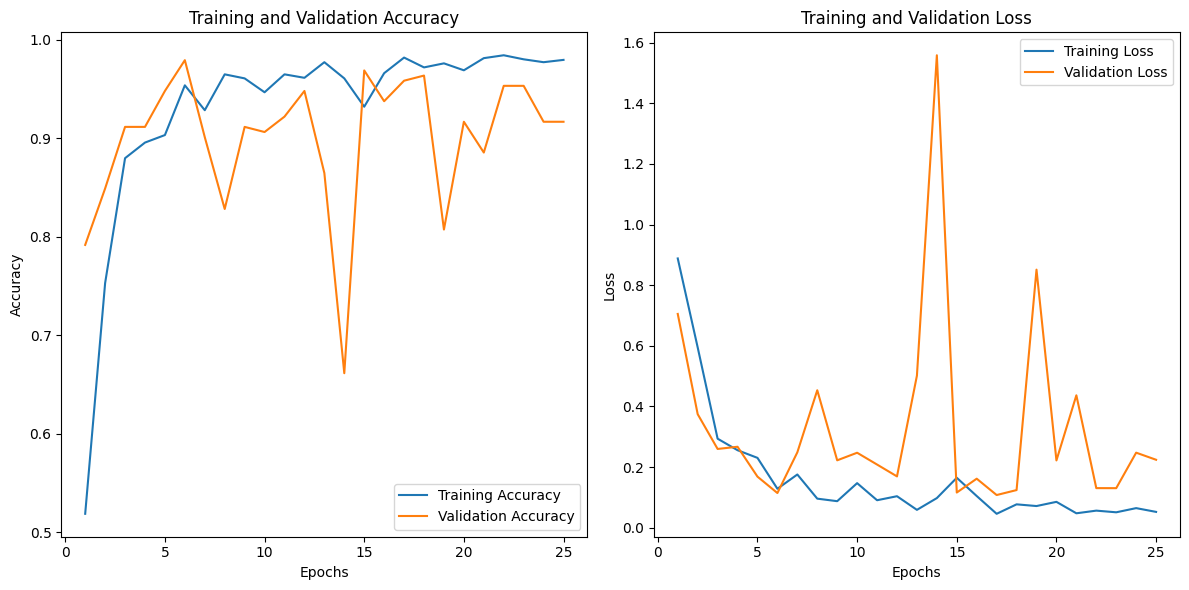

In [ ]:
EPOCHS = 25

# Create the plots
plt.figure(figsize=(12, 6))  # Adjust the figure size
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), acc, label='Training Accuracy')
plt.plot(range(1, EPOCHS + 1), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), loss, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

## **Performing Inference on Sample Images Using a Custom Inference Function**

In [ ]:
import numpy as np
import tensorflow as tf

def predict(CNN_model, img):
    # Convert the image to a NumPy array and add an extra batch dimension
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Perform inference (prediction) using the model
    predictions = CNN_model.predict(img_array)

    # Get the predicted class label and confidence
    class_names = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


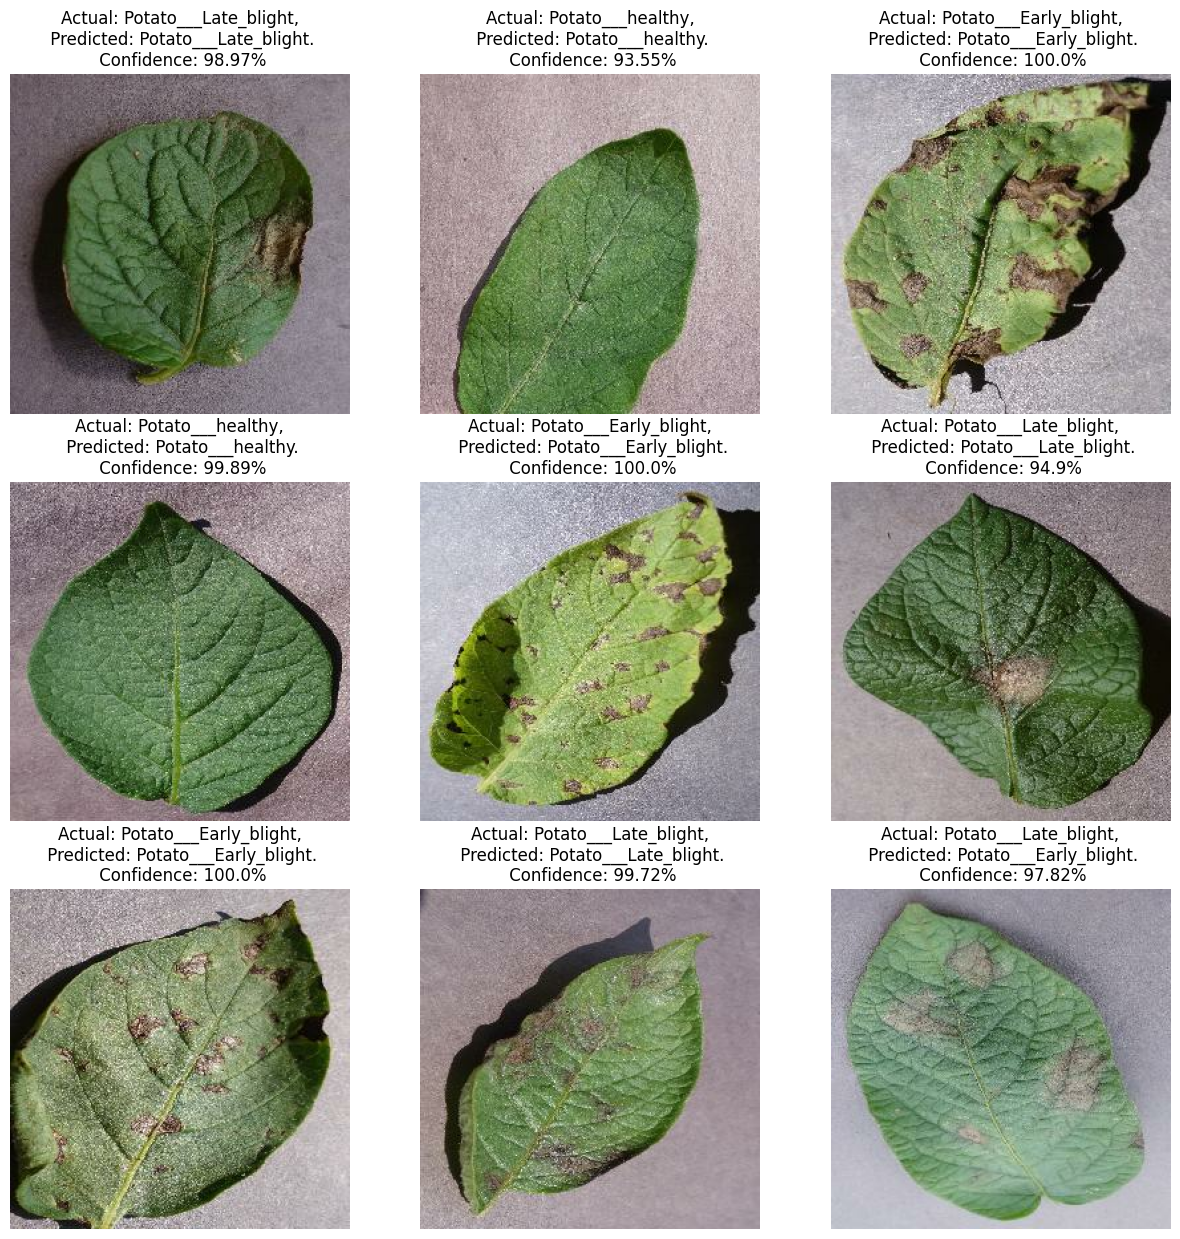

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(CNN_model, images[i].numpy())
        actual_class = class_names[labels[i]]  # Assuming you have defined class_names earlier

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

plt.show()

## **RESNET Model Architecture**

In [ ]:
from tensorflow.keras import models, layers, Input

def residual_block(input_tensor, filters, kernel_size=3):
    x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(input_tensor)
    x = layers.Conv2D(filters, kernel_size, activation=None, padding='same')(x)
    # Adjust for the spatial dimensions reduction
    if input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, kernel_size=1, padding='same')(input_tensor)
    x = layers.Add()([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

no_of_classes = 3

# Input layer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
resize_and_rescale = layers.Rescaling(1./255)(inputs)

# Convolutional layers
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(resize_and_rescale)
x = layers.MaxPooling2D((2, 2))(x)

# Add Residual blocks
x = residual_block(x, 32)
x = layers.MaxPooling2D((2, 2))(x)

x = residual_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)

x = residual_block(x, 128)
x = layers.MaxPooling2D((2, 2))(x)

x = residual_block(x, 256)
x = layers.MaxPooling2D((2, 2))(x)

x = residual_block(x, 512)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten and dense layers
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(no_of_classes, activation='softmax')(x)

# Create the model
resnet_model = models.Model(inputs=inputs, outputs=outputs)

In [ ]:
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 254, 254, 32  896         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

## **Compiling the resnet_model with adam optimizer and accuracy as the metric**

In [ ]:
# Compile the model
resnet_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

## **Training the resnet_model using fit() Method**

In [ ]:
# Train the model
model_train2 = resnet_model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=25,
)

Epoch 1/25
54/54 [==============================] - 20s 245ms/step - loss: 0.8582 - accuracy: 0.5411 - val_loss: 0.7915 - val_accuracy: 0.6406
Epoch 2/25
54/54 [==============================] - 13s 239ms/step - loss: 0.5352 - accuracy: 0.7969 - val_loss: 0.9441 - val_accuracy: 0.6510
Epoch 3/25
54/54 [==============================] - 13s 235ms/step - loss: 0.3663 - accuracy: 0.8627 - val_loss: 0.3941 - val_accuracy: 0.8438
Epoch 4/25
54/54 [==============================] - 13s 234ms/step - loss: 0.3499 - accuracy: 0.8744 - val_loss: 0.7967 - val_accuracy: 0.7812
Epoch 5/25
54/54 [==============================] - 13s 236ms/step - loss: 0.2672 - accuracy: 0.8991 - val_loss: 0.5395 - val_accuracy: 0.7292
Epoch 6/25
54/54 [==============================] - 13s 234ms/step - loss: 0.2612 - accuracy: 0.9090 - val_loss: 0.9879 - val_accuracy: 0.6615
Epoch 7/25
54/54 [==============================] - 13s 235ms/step - loss: 0.2776 - accuracy: 0.9049 - val_loss: 0.3931 - val_accuracy: 0.8438

## **Evaluating the scores of the resnet_model on the test dataset**

In [ ]:
resnet_model_scores = resnet_model.evaluate(test_dataset)

8/8 [==============================] - 0s 12ms/step - loss: 0.0136 - accuracy: 0.9961


In [ ]:
resnet_model_scores

[0.013608003035187721, 0.99609375]

In [ ]:
model_train2

In [ ]:
model_train2.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [ ]:
model_train2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
model_train2.history['loss']

[0.8582413792610168,
 0.5351855754852295,
 0.3663049638271332,
 0.3498944342136383,
 0.2672266662120819,
 0.26115402579307556,
 0.2776009738445282,
 0.24741080403327942,
 0.16336290538311005,
 0.16937629878520966,
 0.10605338215827942,
 0.1892465054988861,
 0.12342732399702072,
 0.07345697283744812,
 0.27922186255455017,
 0.07693028450012207,
 0.08563418686389923,
 0.0824810266494751,
 0.0632278323173523,
 0.045199550688266754,
 0.05656981095671654,
 0.03410831093788147,
 0.049789611250162125,
 0.04252078756690025,
 0.05469552055001259]

In [ ]:
model_train2.history['accuracy']

[0.5410798192024231,
 0.7969483733177185,
 0.8626760840415955,
 0.8744131326675415,
 0.8990610241889954,
 0.9090375304222107,
 0.9049295783042908,
 0.920187771320343,
 0.9372065663337708,
 0.9383803009986877,
 0.9606807231903076,
 0.9289906024932861,
 0.9530516266822815,
 0.9765258431434631,
 0.9102112650871277,
 0.9741784334182739,
 0.96772301197052,
 0.9694835543632507,
 0.9765258431434631,
 0.9818075299263,
 0.9800469279289246,
 0.9888497591018677,
 0.9823943376541138,
 0.9853286147117615,
 0.9800469279289246]

In [ ]:
# Extract training and validation accuracy and loss from the history object
acc = model_train2.history['accuracy']
val_acc = model_train2.history['val_accuracy']
loss = model_train2.history['loss']
val_loss = model_train2.history['val_loss']

# Print the extracted metrics
print("Training Accuracy:", acc)
print("Validation Accuracy:", val_acc)
print("Training Loss:", loss)
print("Validation Loss:", val_loss)

Training Accuracy: [0.5410798192024231, 0.7969483733177185, 0.8626760840415955, 0.8744131326675415, 0.8990610241889954, 0.9090375304222107, 0.9049295783042908, 0.920187771320343, 0.9372065663337708, 0.9383803009986877, 0.9606807231903076, 0.9289906024932861, 0.9530516266822815, 0.9765258431434631, 0.9102112650871277, 0.9741784334182739, 0.96772301197052, 0.9694835543632507, 0.9765258431434631, 0.9818075299263, 0.9800469279289246, 0.9888497591018677, 0.9823943376541138, 0.9853286147117615, 0.9800469279289246]
Validation Accuracy: [0.640625, 0.6510416865348816, 0.84375, 0.78125, 0.7291666865348816, 0.6614583134651184, 0.84375, 0.875, 0.84375, 0.8541666865348816, 0.8854166865348816, 0.9427083134651184, 0.8802083134651184, 0.9895833134651184, 0.859375, 0.9635416865348816, 0.921875, 0.96875, 0.9739583134651184, 0.8697916865348816, 0.984375, 0.9947916865348816, 0.984375, 0.9791666865348816, 0.9791666865348816]
Training Loss: [0.8582413792610168, 0.5351855754852295, 0.3663049638271332, 0.3498

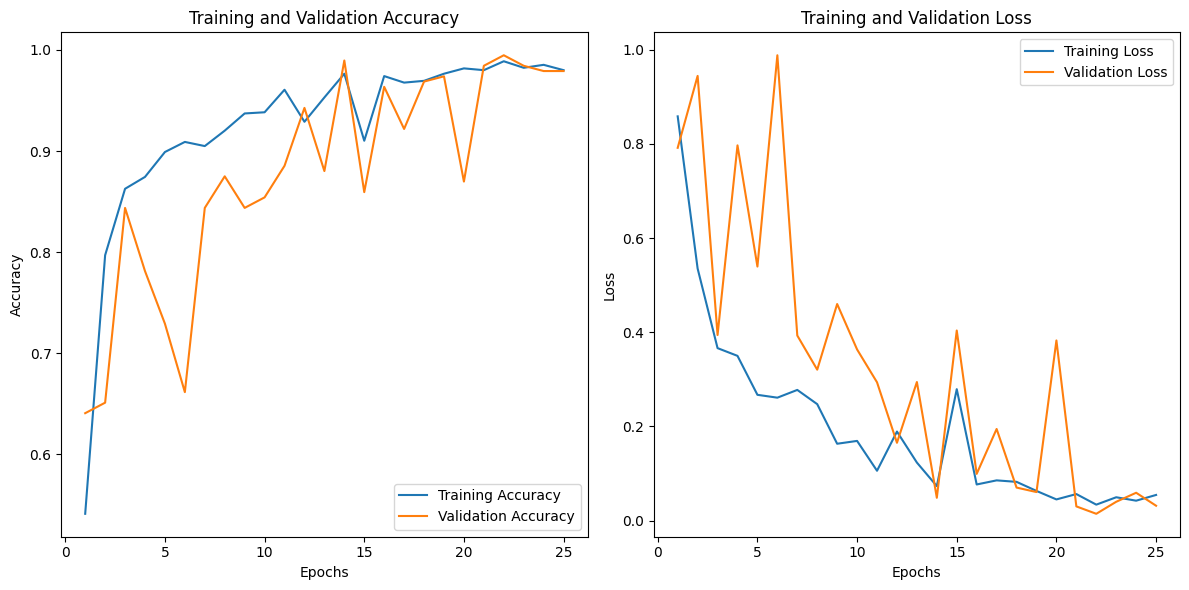

In [ ]:
EPOCHS = 25

# Create the plots
plt.figure(figsize=(12, 6))  # Adjust the figure size
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), acc, label='Training Accuracy')
plt.plot(range(1, EPOCHS + 1), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), loss, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

## **Performing Inference on Sample Images Using a Custom Inference Function**

In [ ]:
import numpy as np
import tensorflow as tf

def predict(resnet_model, img):
    # Convert the image to a NumPy array and add an extra batch dimension
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Perform inference (prediction) using the model
    predictions = resnet_model.predict(img_array)

    # Get the predicted class label and confidence
    class_names = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


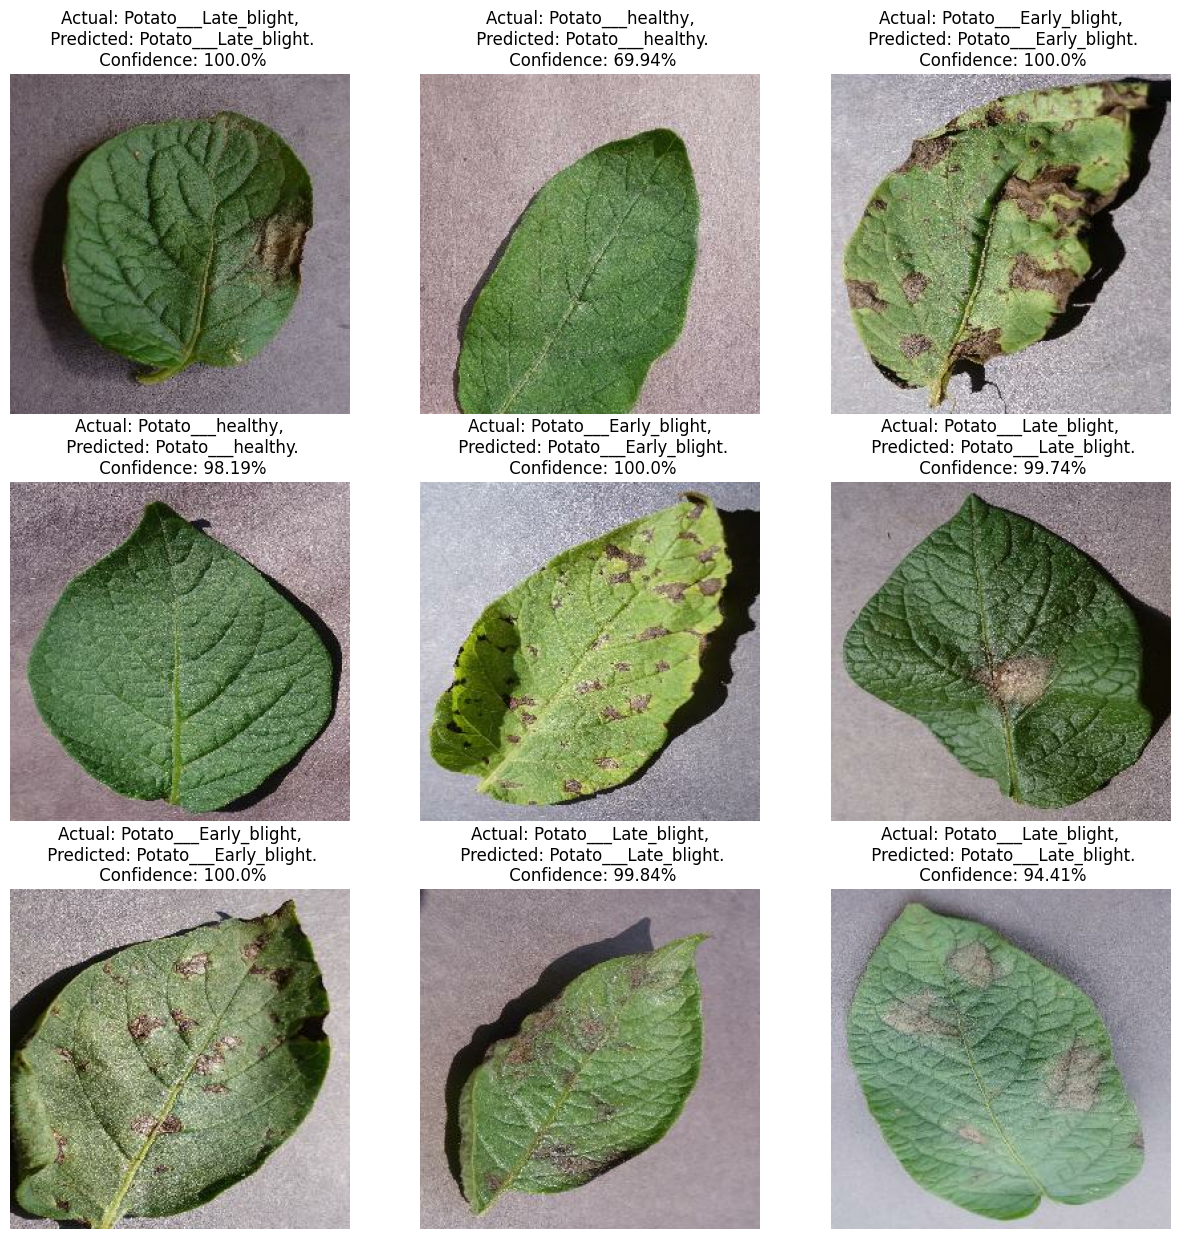

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(resnet_model, images[i].numpy())
        actual_class = class_names[labels[i]]  # Assuming you have defined class_names earlier

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

plt.show()

## **Saving the models**

In [ ]:
CNN_model.save('Capstone_Model_1')
resnet_model.save('Capstone_Model_2')

## **References**

[1] https://github.com/codebasics/potato-disease-classification/blob/main/training/potato-disease-classification-model.ipynb

[2] https://www.kaggle.com/datasets/arjuntejaswi/plant-village

[3] https://www.mdpi.com/2073-4395/12/10/2395

[4] https://plantmethods.biomedcentral.com/articles/10.1186/s13007-021-00722-9
